<p style="text-align: justify; font-size:18px; color:black; font-weight:normal;">
I will share my understanding of building LLM from scratch. The codes, figures, and information I will share are from the book
    <a href="https://learning.oreilly.com/library/view/build-a-large/9781633437166/" target="_blank">"Build a Large Language Model (From Scratch)"</a> by Sebastian Raschka. I added codes from Chap-3 & 4. 
    <br><br>
Initially, I will check for the availability of GPU, then check for the version inside jupyter environemnt. The environment setup is prepared following the book and the supporting GitHub repo (and YouTube video as well). I will empty any existing cache memory.

</p>

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.1
torch version: 2.6.0
tiktoken version: 0.9.0


In [4]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

<p style="text-align: justify;font-size:14px; color:black; font-weight:bold;">
   
Let us first check the architecture of an GPT model which is a decoder only LLM in the following figure. The data flows from the bottom starting with tokenization, followed by token embedding augmented with position embedding to prepare the input embedding for the LLM model. 
<br></br>
The input embedding contains tensors that passes through a sequence of transformer blocks (blue colored zone, 12 for 124M gpt-2 model). Each transformer block has a multihead attention, layer normalization with nonlinear (GeLU) activation, feed forward neural network layers with dropout. 
</p>

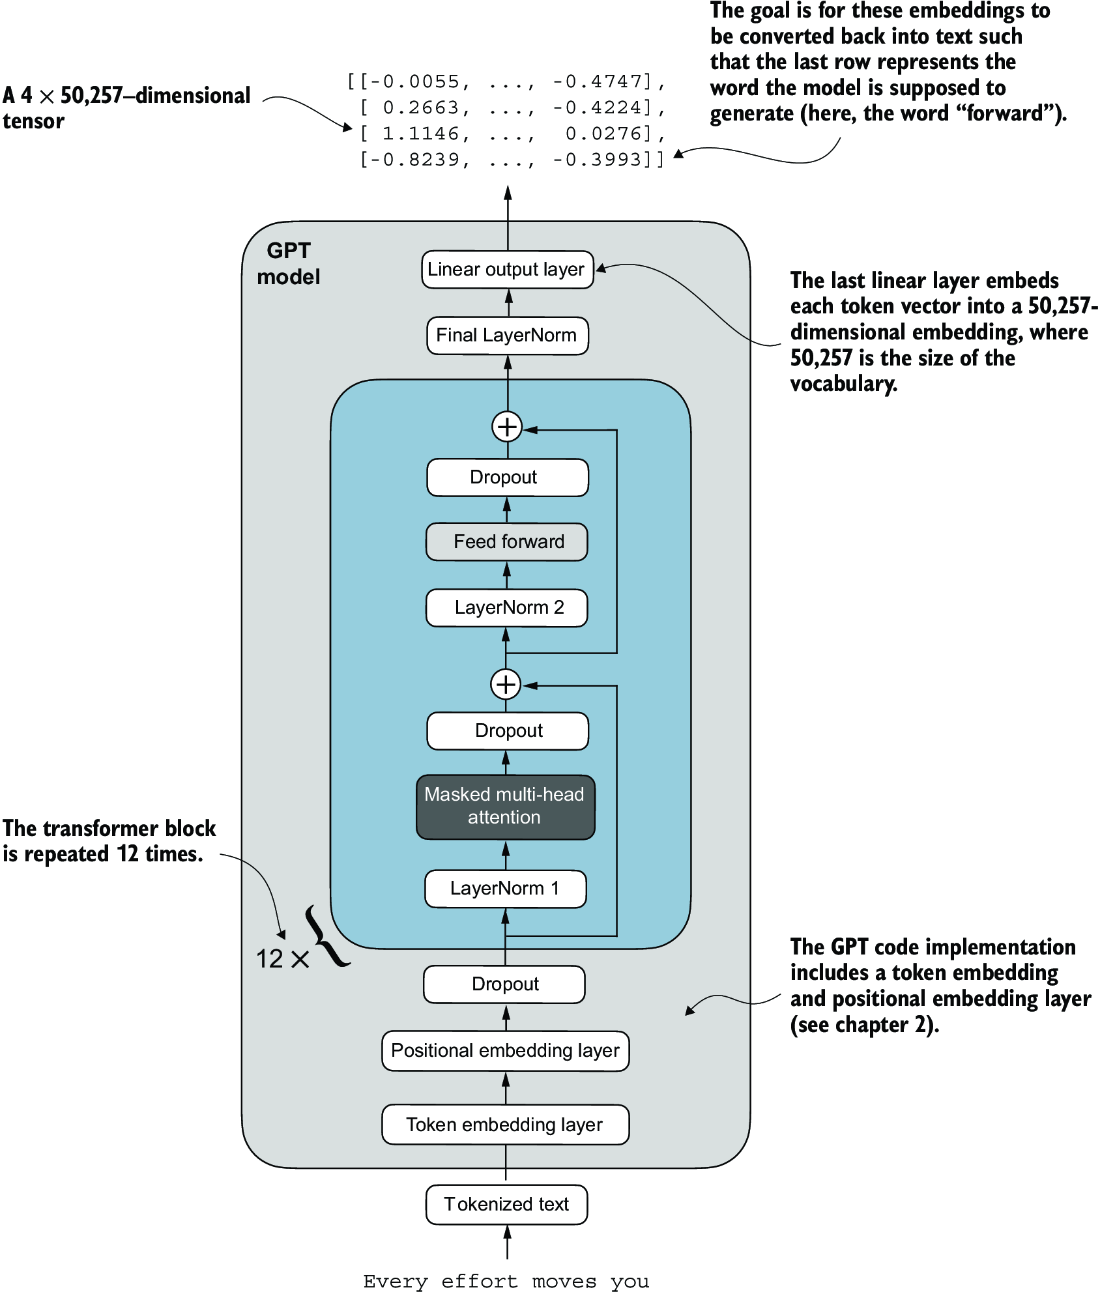

<p style="text-align:justify; font-size:14px;font-weight:bold">
Let's import the necessary library for this notebook.
</p>

In [5]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(123)

<p style="text-align:justify; font-size:14px;font-weight:bold">
The configuration used for creating GPT-2 model are given in a dictionary below.
</p>

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers or attention block
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## 1. Data Prepration to create Input Embedding and load into LLM

<p style="text-align:justify;font-size:14px;font-weight:normal;">
The first step in LLM is to create dataset and feed the token ids into the model using dataloader. You will learn details about the data preprocessing step from Chap-2 of the book. I have also shared my notes from Chap-2 in <a href="https://llm4energy.blogspot.com/2025/03/dataprep-pre-line-height-125-td.html">Data Preparation for Large Language Model</a> to my blogger id <a href="https://llm4energy.blogspot.com/">LLM4Energy</a>
<br></br>
The dataset class creates input:output pairs and create tensors from embedded token ids. The dataloader helps to load the data in batched to the LLM.
The following figure (Figure 2.19) shows the snippet of data preprocessing.

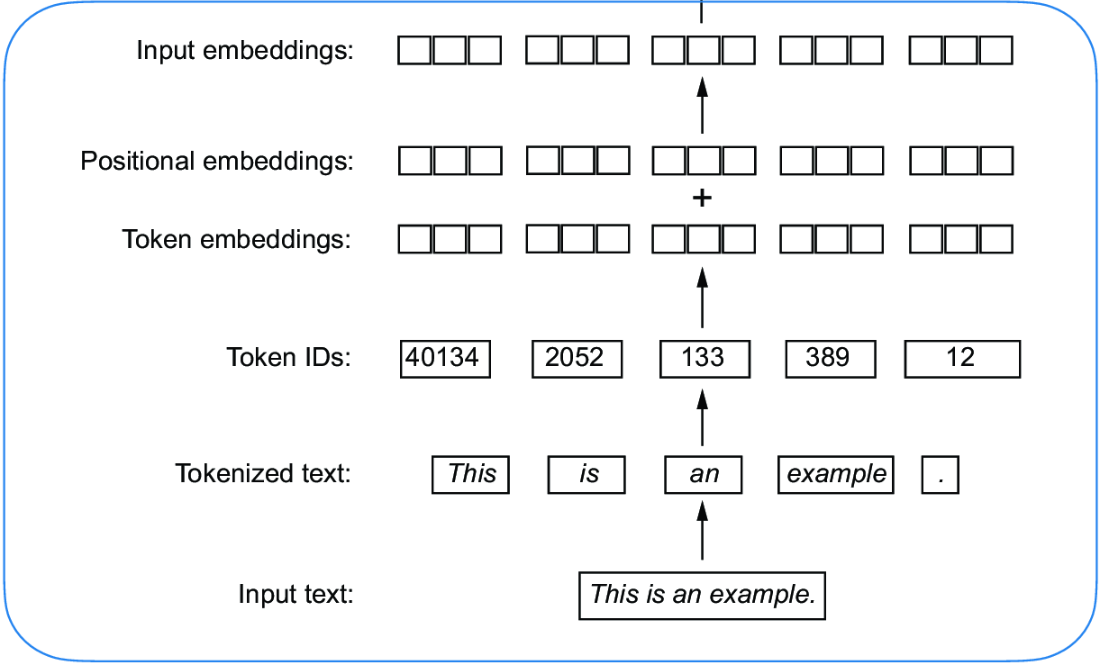
</p>

In [8]:
torch.manual_seed(123)

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

## 2. Multihead Attention to create Context vectors

<p style="text-align: justify; font-size:14px; color:black; font-weight:normal;">  
When a query or input text is fed into LLM, tokenization process creates input embedding containing semantic and position information of each tokens. However, they lack the information among the tokens, i.e., relationship of each tokens with other tokens. Attention mechanism solves this problem by creating CONTEXT vectors from each of the input vectors. Context vector contains the relationship information among the input vectors on top of semantic relationship and position info. We will discuss the self-attention and causal attention first, then will briefly discuss about Multihead attention.<br></br>
    Text generation LLM can generate one token at a time. When generating the next token, information from the previous tokens are passed through the transformer blocks. To generate new tokens from input query, LLM not only needs to know the neighbouring words or tokens, but they are required to learn the entire context. In the next word generation process, the model needs to give more attention to some words than others. The self-attention mechanism ensures that each position in the input sequence interacts with all other positions based on weighted attention, capturing contextual dependencies. It assesses and learns the relationships and dependencies between various parts of the input itself. The goal of self-attention is to create "CONTEXT" vector (enriched embedding vector) for each input element that combines information from all other inputs elements, of course, with dissimilar attention or weights. It is worth to mention that these attention weights are the normalized attension scores using pytorch's softmax function. These attention scores are found from dot product of query vector and all other input vectors. <br>
Let's discuss the following example where input sentences is "Attention is all you need".<br>
The input tokens are Att, ention, is, all, you, need. <br>
Considering 3-dim embedding for token and position, input tokens and corresponding 3-dim input embedding vectors are --
    <pre>
#Att       [ 0.1818,  0.2991,  1.8299]
#ention    [-0.4610, -0.1466, -0.0216]
#is        [-0.3693,  0.3465, -1.4131]
#all       [ 1.3594, -1.1787,  0.3624]
#you       [-0.6176, -1.1166, -0.5720]
#need      [-0.1682, -1.1246,  1.2419]
    </pre>
</p>

<p style="text-align: justify; font-size:14px; color:black; font-weight:normal;">  
For the third token -"is"- input vector is [-0.3693,  0.3465, -1.4131]. The attetion score for the query "is" will be dot product of query vector (i.e. [-0.3693,  0.3465, -1.4131]) and all other input vectors shown above. Softmax function is applied to normalized these scores to get attention weights. Finally. the CONTEXT vector is calculated by multiplying attention weights to input embedding vectors and summing up.
<br></br>
The self attention mechanism described above is a simplified version without trainable or learned parameters (weights). In actual attention mechanism, three distinct trainable weight parameters are considerd (query, key, value, q_k_v) using torch.nn.Linear() module. Given a query q, we want to know which key k the query should pay "attention"
to with respect to the associated value v. Please read Chap-3 for getting detailed information. 
<br></br>
After creating context vector, causal or masked attention is applied which restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. The following figure depicts the idea (In book--Figure 3.19)

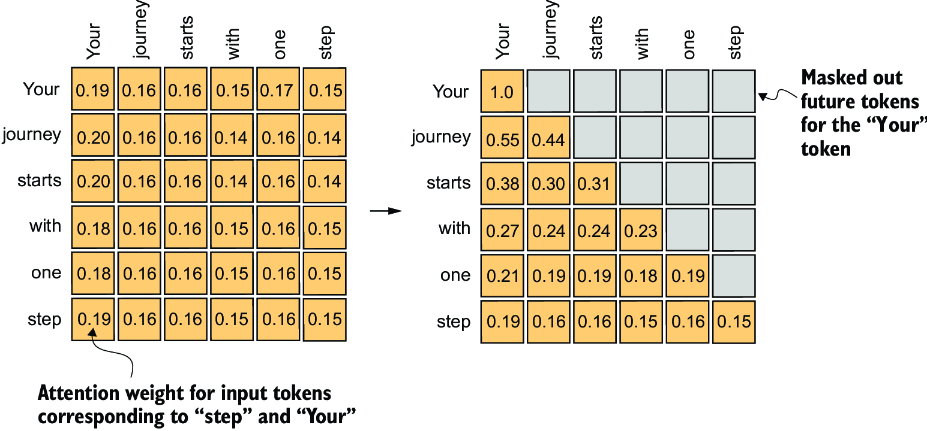
</p>

<p style="text-align:justify; font-size:14px; font-weight:normal">
Dropout may be applied to randomly ingnore some of the weight parameters which in terms help to reduce overfitting. 
</p>

In [122]:
### Codes for the tokenization process shown above

# torch.manual_seed(123)
# # import gpt tokenizer
# tokenizer = tiktoken.get_encoding('gpt2')
# # tokenize the text
# input_token_ids = tokenizer.encode("Attention is all you need")
# # printing input tokens and token_ids
# for ids in input_token_ids:
#     input_tokens = tokenizer.decode([ids])
#     print(input_tokens,str(ids))
    
# ## Temporary 3 dim embedding layers
# token_embedding_layer = torch.nn.Embedding(50257, 3)
# position_embedding_layer = torch.nn.Embedding(len(input_token_ids),3)

# #input embedding
# input_embedding= token_embedding_layer(torch.tensor(input_token_ids))+position_embedding_layer(torch.arange(len(input_token_ids)))
# print('input_embedding_dim: ',input_embedding.shape)
# print('\ninput_embedding :- \n',input_embedding)

<p style="text-align:justify; font-size:14px; font-weight:normal">
 
</p>

<p style="text-align:justify; font-size:14px; font-weight:normal">
Instead of using single Causal attention, multiple Causal attention modeules can be used which is called Multihead Attention. Head refers to the number of Causal attention modules being used. Each of these modules have seperate query, key, value weight matrix and creates multiple CONTEXT vector for same input vectors. <br>
In GPT model, a single MultiHeadAttention class is used in stead of stacking several causal attention modules. For fast and memory efficient calculations, single weight matrix for each of query, key and value are created. Then they are split into multiple vectors based on the number of heads. 
    For gpt model, embedding dimension for input and output are same sized(d_in = d_out). The following figure shows the high level steps to create context vector from input (Figure 3.24)
    
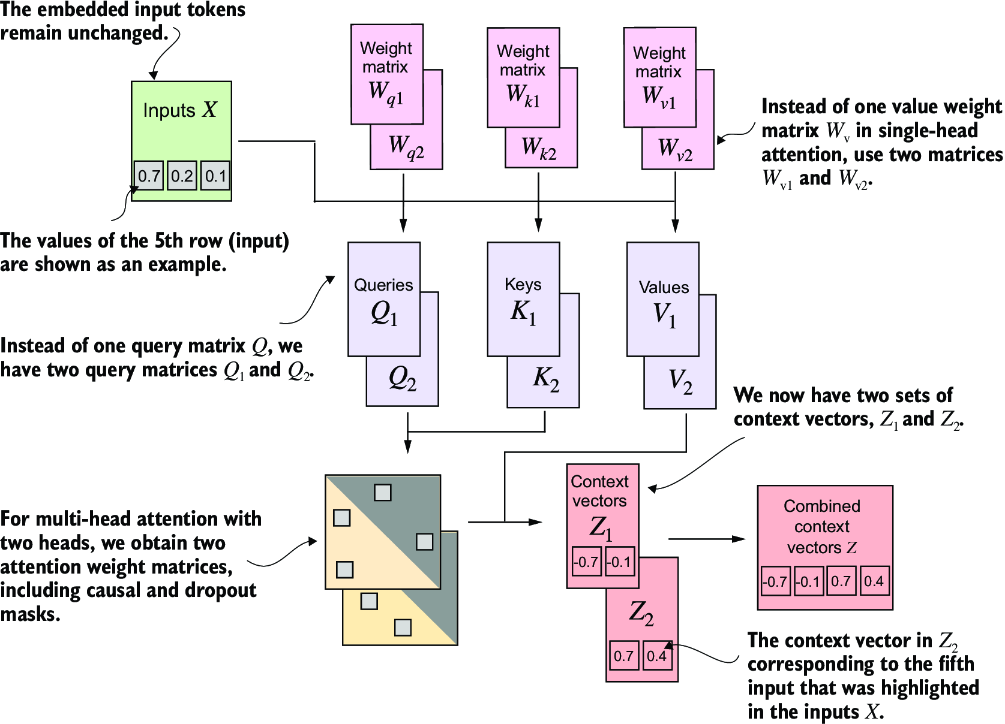
</p>

In [16]:
torch.manual_seed(123)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape #b- no of batch
        
        # (b, num_tokens, d_in) x (d_in, d_out) --> (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

## 3. Creating Transformer Block

<p style="text-align:justify; font-size:14px; font-weight:normal">
As mentioned earlier that each transformer block has a multihead attention, layer normalization with nonlinear (GeLU) activation, feed forward neural network layers with dropout. 
The following figure shows the architecture of Transformer block (Figure 4.3).

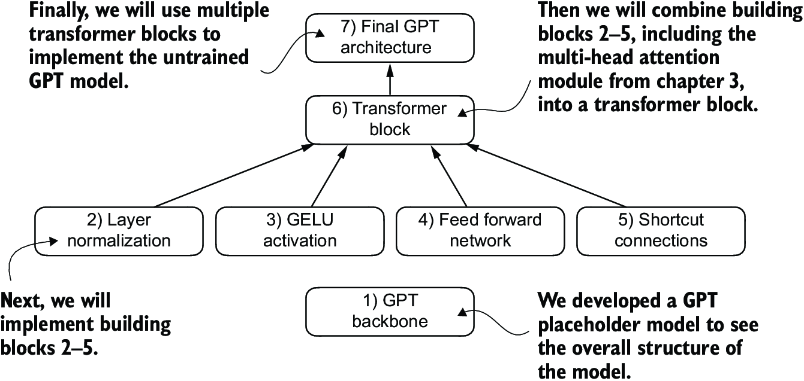
</p>

<p style="text-align:justify; font-size:14px; font-weight:normal">
The first item in transformer block is the Layer Normalization. It normalizes the data with a mean of 0 and variance of 1. This helps the for faster convergence to effective weights during training process. Normalization is similar to statistics' z-score calculation with exception of addition eps to avoid division by zero. The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model’s performance on its training task. 
</p>

In [7]:
torch.manual_seed(123)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<p style="text-align:justify; font-size:14px; font-weight:normal">
The next item is to create a feedforward network with GeLU activation. The feewdfor module consists of one linear layer that converts the input vector of dimension (batch, token, emb_dim) to (batch, token, 4 * emb_dim). Then comes the GeLU activation layer that includes some nonlinearity to the model. Nonlinearity helps to capture more complex information. Expanding the vector dimension helps the model to explore richer reprsentation space. The final linear layer converts the vector dimension back to same as input dimension. This is necessary so that we can stack multiple layers. 
</p>

In [8]:
torch.manual_seed(123)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [9]:
torch.manual_seed(123)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

<p style="text-align:justify; font-size:14px; font-weight:normal">
We can now construct the Transformer block. The Multihead attention layer creates context vector from inputs which analyzes the relationships among the input vectors. Two Normalization layers added before both the attention and feedforward layers. Normalization speeds up the convergence to effective weights during training. The feedforward layer modifies the context vector. In order to avoid vanishing gradient problem during back propagation (training), shortcut layers are added after both the attention and feedforward networks. The shortcut connection simply adds the input vectors to the output of attention layers and feedforward layers. There are also dropout layers added to avoid overfitting during training. Dropout randomly ignores some of the weight parameters from the context vector. <br></br>
The output of the Transformer network is a context vector having same dimension as input vector. This context vector accumulates information from the entire input sequence. The same dimension of input and output vector ensures one to one relationship amont input and output. 
</p>

In [10]:
torch.manual_seed(123)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

## 4. Coding the GPT model

<p style="text-align:justify; font-size:14px; font-weight:normal">
We can now implement the GPT-2 model using stack to different networks. In 124M GPT model, 12 layers of Transformer blocks are used. <br></br>
GPT models is the final architecture of our LLM. When a query is given to GPT model, it first preprocess the data to create input embedding vectors in batches. Then it passes through 12 layers of transformer blocks that creates context vector of same dimensions as inputs. Another layer normalization is applied to stabilize the training. The final linear transformation creates logits which have dimension same as vocab size. <br></br>
Example: input embedding creates vector of size (50257, 768) and final logits will have dimension of (768, 50257). For a batch size of 2, 1024 numbers of tokens--the model will output logits of size (2,1024,50257). The third dimension of size 50257 acts as the untrained probability to find the index of tokens from a token embedding look up table of size (50257, 768).
</p>

In [11]:
torch.manual_seed(123)

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

<p style="text-align:justify; font-size:14px; font-weight:normal">
Our GPT-2 model is now constructed. Let's check the model's parameter and test its ability with some example.
</p>

In [14]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0) # row wise position of txt1 and txt2 
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [17]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<p style="text-align:justify; font-size:14px; font-weight:normal">
It can be seen from the above that there are 163M parameters. It is called 124M model because the original GPT-2 model used weight tying concept where embedding weights (50257) are used in output layer.
</p>

In [20]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [21]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<p style="text-align:justify; font-size:14px; font-weight:normal">
The following function is self-explanatory and no need to explain further. LLm predicts next token and append it to context and the process goes on. In order to limit its maximum new token generation, the loop will terminate when it reaches the length of max_new_tokens. Each component will be understood better if we go to the end of out notebook and have a look at each code examples. <br>
The model's output is logits with outer dimension equal to vocab size. Softmax function converts the logits into a probability distribution from which we identify the position with the highest value via torch.argmax.
</p>

In [22]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [27]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [24]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [25]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


<p style="text-align:justify; font-size:14px; font-weight:normal">
We can see that the model generate something that makes no sense. Since the model is not trained on data, it can not predict words efficiently.
</p>